# OPTIMAL INTERPOLATION

Codi extret i adaptat de Step_1_Compute_OI_CTD_Leg_1_calibration.py

***

In [1]:
import numpy                 as np
import matplotlib.pyplot     as plt
import glob
import gsw
import matplotlib.gridspec   as gridspec
from scipy                   import interpolate 
import netCDF4               as netcdf
import Tools_OI              as toi 
from matplotlib              import dates as mdates 
from datetime import datetime
from scipy                   import interpolate
import xarray as xr
import cartopy.crs as ccrs
import time
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


In [2]:
import math

def meters_to_degrees(meters, latitude=39.73):
    # Earth's radius in meters
    earth_radius = 6378137

    # Convert latitude to radians
    lat_radians = math.radians(latitude)

    # Calculate the change in latitude (degrees)
    lat_degrees = meters / earth_radius * 180 / math.pi

    # Calculate the change in longitude (degrees)
    lon_degrees = meters / (earth_radius * math.cos(lat_radians)) * 180 / math.pi

    return lat_degrees, lon_degrees

In [3]:
def create_nc(savedirnc, filename, svar, lonOI, latOI, dep):
    
    '''
    Create a netcdf file
    '''
    
    nc = netcdf.Dataset(savedirnc + filename, 'w', format='NETCDF3_CLASSIC')
    
    # Create the dimensions...
    nc.createDimension('dep', dep.shape[0])   
    nc.createDimension('lat', lonOI.shape[0])    
    nc.createDimension('lon', lonOI.shape[1])    

    # Create the variables...
    nc.createVariable(svar,        'f4', ('dep', 'lat', 'lon'))
    nc.createVariable('error',     'f4', ('dep', 'lat', 'lon'))
    nc.createVariable('longitude', 'f4', ('lat', 'lon'))
    nc.createVariable('latitude',  'f4', ('lat', 'lon'))
    nc.createVariable('depth',  'f4', ('dep'))

    
    # Write in variable attributes...
    if svar == 'ptem':
        nc.variables[svar].long_name  = 'Potential Temperature'
        nc.variables[svar].units      = '[deg C]'
        
    elif svar == 'psal':
        nc.variables[svar].long_name  = 'Practical Salinity'
        nc.variables[svar].units      = '[PSU]'
        
    elif svar == 'sigt':
        nc.variables[svar].long_name  = 'Potential density anomaly, sigma-theta'
        nc.variables[svar].units      = '[kg/m^3]'
        
    elif svar == 'pres':
        nc.variables[svar].long_name  = 'Pressure'
        nc.variables[svar].units      = '[db]'
        
    elif svar == 'oxy':
        nc.variables[svar].long_name  = 'mass_concentration_of_oxygen_in_sea_water'
        nc.variables[svar].units      = '[mg/l]'  
        
    elif svar == 'chlo':
        nc.variables[svar].long_name = 'chl_a_fluorescence - chlorophyll A fluorescence in sea water'
        nc.variables[svar].units     = ''  
    else:
        print ('Provide the variable!')
        
     
    nc.variables['error'].long_name    = 'Normalized error of the OI'
    nc.variables['error'].units        = ''      
        
    nc.variables['longitude'].long_name    = 'Longitude of the profiles'
    nc.variables['longitude'].units        = 'degrees'  
    
    nc.variables['latitude'].long_name     = 'latitude of the profiles'
    nc.variables['latitude'].units         = 'degrees' 
    
    nc.variables['depth'].long_name        = 'interpolated depth of the data'
    nc.variables['depth'].units            = 'm' 
    
    nc.close()   
    
    print('File created! >>>', filename)

def save_to_nc(savedirnc, filename,  svar, varint, errint, lonOI, latOI, dep):

    # ------------------------------------------
    # Save data
    # ------------------------------------------
     
    nc = netcdf.Dataset(savedirnc + filename, 'a', format='NETCDF3_CLASSIC')
    nc.variables[svar][:]           = varint
    nc.variables['error'][:]        = errint
    nc.variables['longitude'][:]    = lonOI
    nc.variables['latitude'][:]     = latOI
    nc.variables['depth'][:]        = dep
    nc.close() 
    
    print('Data saved! >>>', filename)

#### Importar els fitxers :

In [69]:
#change:
dir_files = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/MVP/smoothed_profiles/files_netcdf_smoothed_10m_0.5m/leg2/'
files = glob.glob(dir_files+'*.nc')
files = np.sort(files)
np.size(files)

245

### Guardar en matrius totes les dades per poder tenir un únic fitxer

dimensio 1: dim_time

dimensio 2: dim_depth



variable 1: Temperatura(dim_time, dim_depth)

variable 2: Salinitat(dim_time, dim_depth)

variable 3: Depth(dim_depth)

variable 4: Time(dim_time)

variable 5: Longitud(dim_time)

variable 6: Latitud(dim_time)

In [72]:
T = np.empty((0, 300)) #per leg 1 és 0,198. per la leg 2 és 0, 300 -> arriba fins 150 m (si no mirar depth.size següent)
S = np.empty((0, 300))
Lon = np.array([])
Lat = np.array([])
Time = np.array([])
# depth és igual en tots els arxius, basta guardar-ne una

In [73]:
for file in files:
    ds = xr.open_dataset(file)
    
    lon = ds.lon.values
    lat = ds.lat.values
    temp = ds.Temp_smooth.values
    sal = ds.Sal_smooth.values
    depth = ds.New_depth.values
    time = ds.time.values
    
    temp_columna = np.reshape(temp, (1,len(temp)))
    T = np.concatenate((T, temp_columna))
    
    sal_columna = np.reshape(sal, (1,len(sal)))
    S = np.concatenate((S, sal_columna))
    
    lon = np.array([lon])
    Lon = np.concatenate((Lon,lon))
    
    lat = np.array([lat])
    Lat = np.concatenate((Lat,lat))
    
    time = np.array([time])
    Time = np.concatenate((time,Time))
    
    Depth = depth
#     print(depth.size)

In [74]:
# Comprovació dimensions
print('dim of T is ', np.shape(T))
print('dim of S is ', np.shape(S))
print('dim of Time is ', np.shape(Time))
print('dim of Lon is ', np.shape(Lon))
print('dim of Lat is ', np.shape(Lat))
print('dim of Depth is ', np.shape(Depth))

dim of T is  (245, 300)
dim of S is  (245, 300)
dim of Time is  (245,)
dim of Lon is  (245,)
dim of Lat is  (245,)
dim of Depth is  (300,)


In [75]:
#np.mean(Lat) #necessari per la funció

In [76]:
# Si es vol passar el temps a format datetime
date_list = [datetime.strptime(date, '%d/%m/%Y %H:%M:%S') for date in Time]

In [77]:
numeric_dates = mdates.date2num(date_list)

### Optimal interpolation method

Text(0.5, 1.0, 'FaSt-SWOT2 MVP sampling')

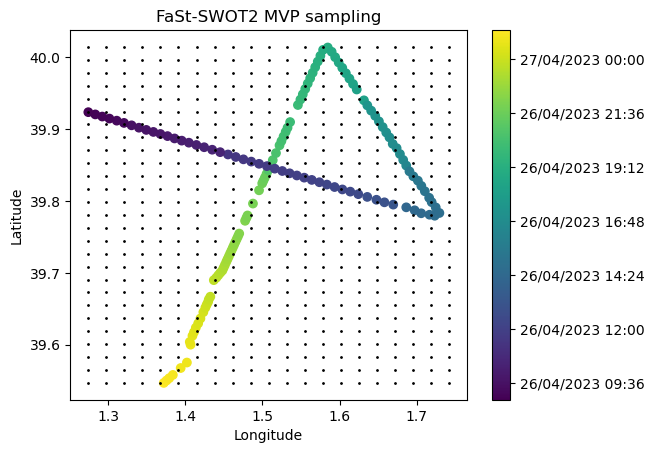

In [60]:
# Create new grid: doble the original grid points
loni_min = Lon.min()
loni_max = Lon.max()
    
lati_min = Lat.min()
lati_max = Lat.max()
    
dx   = 2000 # m aprox.

# Converteix dx = 2km a graus en latitud i longitud (funció)
dx_lon = meters_to_degrees(2000)[1]
dx_lat  = meters_to_degrees(2000)[0]

loni = np.arange(loni_min, loni_max+dx_lon, dx_lon)
lati  = np.arange(lati_min, lati_max+dx_lat, dx_lat)

    
[lonOI, latOI] = np.meshgrid(loni, lati)

plt.figure()
scatter = plt.scatter(Lon, Lat,c=numeric_dates)
plt.colorbar(scatter, format=mdates.DateFormatter('%d/%m/%Y %H:%M'))
plt.scatter(lonOI, latOI, s=1, c='k')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('FaSt-SWOT2 MVP sampling') #change

In [78]:
# Parameters
ang    = 0
eps    = 0.03
streps = '003' 
    
print('')
print('STD of the original data - T...', np.nanstd(T))
print('STD of the original data - S...', np.nanstd(S))
print('')
ieT = 0.01
ieS = 0.002 #from cruise report calibration
    
print('T - Assuming an instrumental error with a STD of...', ieT)
print('S - Assuming an instrumental error with a STD of...', ieS)
print('eps recomended for T OI...', ieT/np.nanstd(T))
print('eps recomended for S OI...', ieS/np.nanstd(S))
print('And you are using an eps of...', eps)


STD of the original data - T... 1.8715513014211298
STD of the original data - S... 0.05200075797349421

T - Assuming an instrumental error with a STD of... 0.01
S - Assuming an instrumental error with a STD of... 0.002
eps recomended for T OI... 0.005343161041007358
eps recomended for S OI... 0.03846097783842763
And you are using an eps of... 0.03


In [79]:
lx     = 20 #20#10 #km
ly     = lx #20#10 #km   

# Variable to interpolate 
    
var  = T 
svar = 'tem'

# var  = S 
# svar = 'sal'

# Loop for each depth layer
varint = np.ones((Depth.shape[0], lonOI.shape[0], lonOI.shape[1]))*np.nan
errint = np.ones((Depth.shape[0], lonOI.shape[0], lonOI.shape[1]))*np.nan
print('Start optimal interpolation...')

Start optimal interpolation...


In [80]:
# Fins a 5m no tenim dades, són nans, per això començar la OI a partir de 5m (posició 10)

# profunditat a partir de la que no hi ha nans
zmin = 5 #m

# index al llarg de l'eix z on Depth més s'acosta a 5 m
ind_min = np.argmin(np.abs(Depth-zmin)) 
print('minimum depth...', Depth[ind_min])

inds_levels = np.arange(ind_min, Depth.shape[0])

minimum depth... 5.0


In [15]:
for izoi in inds_levels:
    print(izoi, Depth[izoi])
    lonikm2d, latikm2d, varint[izoi], errint[izoi] = toi.compute_OI_2d(Lon,Lat,var[:, izoi],loni,lati,lx,ly,ang,eps,'plane')


10 5.0
11 5.5
12 6.0
13 6.5
14 7.0
15 7.5
16 8.0
17 8.5
18 9.0
19 9.5
20 10.0
21 10.5
22 11.0
23 11.5
24 12.0
25 12.5
26 13.0
27 13.5
28 14.0
29 14.5
30 15.0
31 15.5
32 16.0
33 16.5
34 17.0
35 17.5
36 18.0
37 18.5
38 19.0
39 19.5
40 20.0
41 20.5
42 21.0
43 21.5
44 22.0
45 22.5
46 23.0
47 23.5
48 24.0
49 24.5
50 25.0
51 25.5
52 26.0
53 26.5
54 27.0
55 27.5
56 28.0
57 28.5
58 29.0
59 29.5
60 30.0
61 30.5
62 31.0
63 31.5
64 32.0
65 32.5
66 33.0
67 33.5
68 34.0
69 34.5
70 35.0
71 35.5
72 36.0
73 36.5
74 37.0
75 37.5
76 38.0
77 38.5
78 39.0
79 39.5
80 40.0
81 40.5
82 41.0
83 41.5
84 42.0
85 42.5
86 43.0
87 43.5
88 44.0
89 44.5
90 45.0
91 45.5
92 46.0
93 46.5
94 47.0
95 47.5
96 48.0
97 48.5
98 49.0
99 49.5
100 50.0
101 50.5
102 51.0
103 51.5
104 52.0
105 52.5
106 53.0
107 53.5
108 54.0
109 54.5
110 55.0
111 55.5
112 56.0
113 56.5
114 57.0
115 57.5
116 58.0
117 58.5
118 59.0
119 59.5
120 60.0
121 60.5
122 61.0
123 61.5
124 62.0
125 62.5
126 63.0
127 63.5
128 64.0
129 64.5
130 65.0
131 65.5
13

In [16]:
''' Save interpolated data'''    
# savedirnc  = main_dir_data + 'PRE_SWOT/post_analysis/'
# filename   = 'PRE-SWOT_CTD_cal2_Leg_'+ leg + '_OI_'+svar+'_L_'+np.str(np.int(lx))+'km_dz_'+np.str(np.int(dz))+'_dx_'+np.str(np.int(dx))+'km.nc'
savedirnc = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/MVP/OI_MVP/interpolated_files/'
filename = 'SWOT_MVP_Leg1' + '_OI_'+svar+'_L_'+str(int(lx))+'.nc' #change

# Create a nc file and save data into it:
create_nc(savedirnc, filename, svar, lonOI, latOI, Depth)
save_to_nc(savedirnc, filename,  svar, varint, errint, lonOI, latOI, Depth)

Provide the variable!
File created! >>> SWOT_MVP_Leg1_OI_tem_L_20.nc
Data saved! >>> SWOT_MVP_Leg1_OI_tem_L_20.nc


*** 
****
## FIGURES

In [86]:
# fig = plt.figure()
# pc= plt.contourf(lonOI, latOI, varint[10], cmap=plt.cm.jet)
# plt.scatter(Lon, Lat, c=var[:,10], vmin=pc.get_clim()[0], vmax=pc.get_clim()[1], \
#                linewidths = 0.4, edgecolors='w', cmap=plt.cm.jet)
# plt.colorbar(pc)
# # plt.title(svar +' OI L='+np.str(np.int(lx))+ 'km  Dep='+ np.str(dd)+'m') #'%03d'%dep[iz]
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

In [87]:
# # check psal
# fig = plt.figure()
# pc= plt.contourf(lonOI, latOI, varint[10], levels=np.linspace(19.2,20.4, 15),cmap=plt.cm.jet)
# plt.scatter(Lon, Lat, c=var[:,10], vmin=19.2, vmax=20.4, \
#                linewidths = 0.4, edgecolors='w', cmap=plt.cm.jet)
# plt.colorbar(pc)
# plt.title(svar +' OI L='+str(int(lx))+ 'km  Dep='+ str(dd)+'m') #'%03d'%dep[iz]
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# # fig.savefig(savefig + 'OI_check_cal_'+svar+'_Dep_'+'%03d'%dd + '.png', dpi=200)  


OBRIR FITXERS (Interpolats)
Guardats abans en aquest mateix codi

In [81]:
# dir_files = '/Users/everger/OneDrive - Universitat de les Illes Balears/SWOT/MVP/OI_MVP/interpolated_files/'
dir_files = 'C:/Users/Usuario/OneDrive - Universitat de les Illes Balears/SWOT/MVP/OI_MVP/interpolated_files/'

# change: Leg1 or Leg2
f_T_L20 = 'SWOT_MVP_Leg2_OI_tem_L_20.nc'
f_S_L20 = 'SWOT_MVP_Leg2_OI_sal_L_20.nc'

In [82]:
# Choose the file you want to plot
f = f_T_L20
ds = xr.open_dataset(dir_files+f)
ds

<xarray.Dataset>
Dimensions:    (dep: 300, lat: 30, lon: 26)
Dimensions without coordinates: dep, lat, lon
Data variables:
    tem        (dep, lat, lon) float32 ...
    error      (dep, lat, lon) float32 ...
    longitude  (lat, lon) float32 ...
    latitude   (lat, lon) float32 ...
    depth      (dep) float32 ...

In [83]:
varint = ds.tem.values #change: sal or tem
err    = ds.error.values
lonOI  = ds.longitude.values
latOI  = ds.latitude.values
depth  = ds.depth.values

In [84]:
pW = np.min(lonOI)                # West boundary
pE = np.max(lonOI)           # East boundary
pS = np.min(latOI)                 # South boundary
pN = np.max(latOI)          # North boundary

PLOT interpolated fields with observations

Text(0, 0.5, 'Lat')

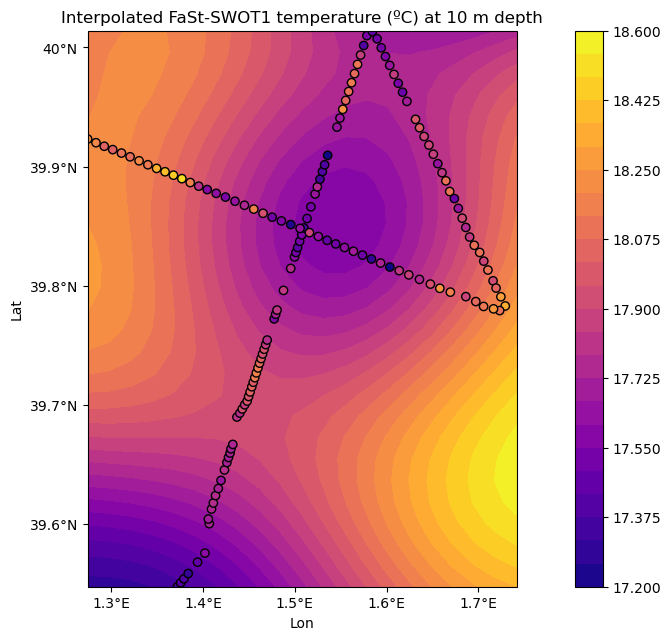

In [42]:
fsize = 12
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111,projection=ccrs.Mercator())

vmin=17.2; vmax=18.6; #LEG1
#vmin=19.2; vmax=20.4;
# pc = ax.pcolor(lonOI,latOI,varint[10],vmin = vmin,vmax = vmax,cmap ="plasma", transform=ccrs.PlateCarree())
pc = ax.contourf(lonOI, latOI, varint[10], levels=np.linspace(vmin, vmax, 25), cmap="plasma", transform=ccrs.PlateCarree())
sc = ax.scatter(Lon,Lat,c=var[:,10],vmin = vmin,vmax = vmax, cmap ="plasma", edgecolors='black',transform=ccrs.PlateCarree())
plt.colorbar(pc)
plt.tight_layout()


xticks = np.arange(-5,11,0.1)
yticks = np.arange(35,47,0.1)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
extent = [pE,pW,pS,pN]
ax.set_extent(extent, ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title('Interpolated FaSt-SWOT1 temperature (ºC) at 10 m depth')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')

PLOT ERRORS

Text(0, 0.5, 'Lat')

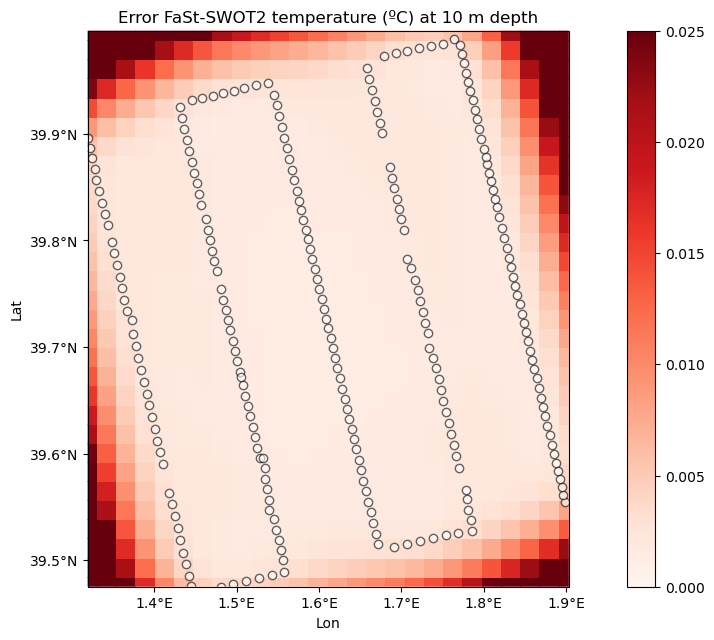

In [85]:
fsize = 12
fig = plt.figure(figsize=(12, 6))
ax = plt.subplot(111,projection=ccrs.Mercator())

vmin=0; vmax=0.025;

pc = ax.pcolor(lonOI,latOI,err[10],vmin = vmin,vmax = vmax,cmap ="Reds", transform=ccrs.PlateCarree())
sc = ax.scatter(Lon,Lat,c='white',edgecolors='k',alpha = 0.6, transform=ccrs.PlateCarree())
#pc = ax.contourf(lonOI, latOI, err[10], levels=np.linspace(vmin, vmax, 25), cmap="plasma", transform=ccrs.PlateCarree())
plt.colorbar(pc)
plt.tight_layout()


xticks = np.arange(-5,11,0.1)
yticks = np.arange(35,47,0.1)
ax.set_xticks(xticks, crs=ccrs.PlateCarree())
ax.set_yticks(yticks, crs=ccrs.PlateCarree())
extent = [pE,pW,pS,pN]
ax.set_extent(extent, ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

plt.title('Error FaSt-SWOT2 temperature (ºC) at 10 m depth')
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')